# Import Packages and Data

In [3]:
# Functional stuff

import pyodbc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None) # Make Pandas display all columns
from sklearn import datasets
import scipy as sp
from subprocess import check_output # Any results you write to the current directory are saved as output.

# Data exploration and vis (graphs/plots)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)}) # Sets the size of plots to be a little bigger.
sns.set_style("darkgrid") # Set style of plots
sns.set_context("notebook") # Set plots to format for Jupyter


# Machine learning functions
from sklearn.linear_model import LogisticRegression #Linear regression proc
from sklearn.feature_selection import RFE #Recursive Feature Elimination -Selects variables based on performance in model.
from sklearn.model_selection import train_test_split # Create our training and test sets.
from scipy.stats import spearmanr # Function to calculate SpearmanR coefficient.
from sklearn.model_selection import GridSearchCV # Cross-validation of hyper-parameters (C, alpha, gamma, etc)
from sklearn.preprocessing import RobustScaler, MinMaxScaler, QuantileTransformer
import statsmodels.api as sm


In [4]:
# Connect to data source with pyodbc

# Set up the connection string
conn = pyodbc.connect('Trusted_Connection=yes', driver='{SQL Server}',server='smc-sql-2017', database='Analytics')

# Create cursor associated with connection
cursor=conn.cursor()

# Write query/ies to sql database that cursor can execute on.
querystring_Test = 'SELECT * FROM load_Kag_AmesTestSplit'
querystring_Train = 'SELECT * FROM load_Kag_AmesTrainSplit'


In [5]:
## Use pandas to insert directly into a pandas dataframe

# All test data
df_test = pd.read_sql(querystring_Test, conn)

# All train data
df_train = pd.read_sql(querystring_Train, conn)

In [6]:
## No longer needed because we're connecting directly to te database.


# Create Data Frames
# Read csv files into dataframes you can use in you notebook.
# data_dir = 'C:/Users/bburns/Python Scripts/Data/Ames/'

# All test data
# df_test = pd.read_csv(data_dir + 'load_Kag_AmesTestSplit.csv')

# All train data
# df_train = pd.read_csv(data_dir + 'load_Kag_AmesTrainSplit.csv')


In [7]:
# Notice that when we look at this, every single data type is an object.  That's not ideal.
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 82 columns):
Column 0         482 non-null object
Id               482 non-null object
MSSubClass       482 non-null object
MSZoning         482 non-null object
LotFrontage      482 non-null object
LotArea          482 non-null object
Street           482 non-null object
Alley            482 non-null object
LotShape         482 non-null object
LandContour      482 non-null object
Utilities        482 non-null object
LotConfig        482 non-null object
LandSlope        482 non-null object
Neighborhood     482 non-null object
Condition1       482 non-null object
Condition2       482 non-null object
BldgType         482 non-null object
HouseStyle       482 non-null object
OverallQual      482 non-null object
OverallCond      482 non-null object
YearBuilt        482 non-null object
YearRemodAdd     482 non-null object
RoofStyle        482 non-null object
RoofMatl         482 non-null object
Exterio

In [8]:
# Convert everything that can be numeric to numeric.
# The errors='ignore' command 
df_train = df_train.apply(pd.to_numeric,errors='ignore')
df_test = df_test.apply(pd.to_numeric,errors='ignore')

# Begin EDA

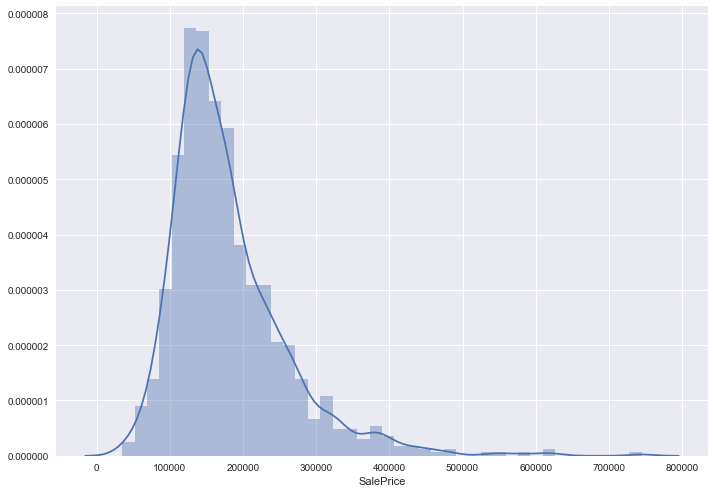

In [9]:
# First, we need to look at our target to see how it will look when compared to my predictors.
sns.distplot(df_train['SalePrice']);

    # We've got a pretty long right tail
    # The left side of the plot is also much steeper than the right.  This makes a lot of sense though, 
    #  when you think about it.  A real starting point for a graph of SalePrice shouldn't actually be $0
    #  because $0 isn't a realistic sale price for a house. An average house isn't $175K and a crappy one is $50,
    #  so what does that mean for our distribution? 

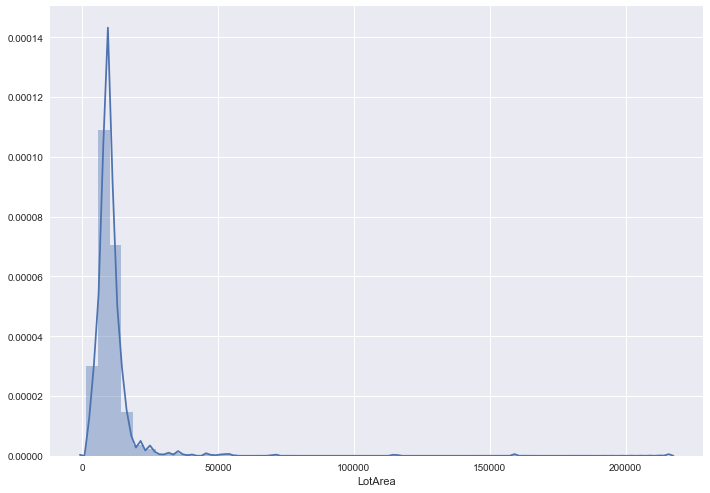

In [10]:
# Check out my actual target predictor variable that I'm looking at.
sns.distplot(df_train['LotArea']);

    # Holy skew!  It's so badly skewed that it's hard to even see the real shape of the mass of data.

In [11]:
# Check out the descriptive stats on these columns.
df_train[['SalePrice', 'LotArea']].describe(percentiles = [.05, .10, .25, .75, .90, .95])

    # Look how crazy these distributions are!
    # The means are crazy close to the 75th percentile!
    # The max values is 18X the 75th for LotArea, and 3.5X for SalesArea!
    # One major thing we always want to look for is comparing the mean to the std.  This is an
    #  excellent indicator of about how much variance you have in your data.
    # Because of this, the STDs are way off too.  Completely unreasonable to the point that I don't think 
    # they can be used to determine outliers.
    # In this case, it might not be a bad idea to just use the "eyeball test" to drop the most extreme outliers. Our
    #  Boxplots below could be a good way to eyeball them.

,SalePrice,LotArea
count,978.000000,978.000000
mean,179709.864008,10578.946830
std,79987.937371,10435.691359
min,34900.000000,1533.000000
5%,89425.000000,3182.000000
10%,105000.000000,5043.700000
25%,128962.500000,7508.750000
50%,160000.000000,9491.000000
75%,213875.000000,11500.000000
90%,275000.000000,14590.300000


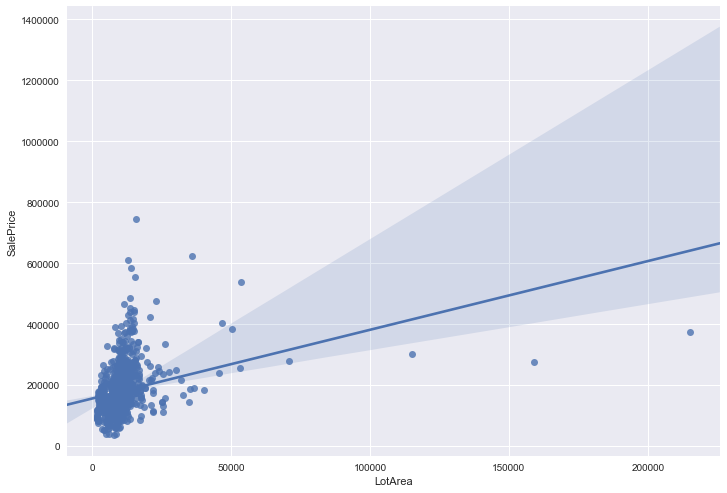

In [12]:
# This plots the predictor against the target in what is typically called a "scatter plot."
# The dark blue line is the regression line.
# The shaded blue band is the confidence interval, which defaults to .95.  This means, roughly, there's a 95% chance the mean
#  falls in this range.  It's a very specific definition, and not to be confused with saying that "95% of values fall into 
#  that range -even though, unofficially, and I never said this, you KIND OF can think about it like that... but don't
#  because that's definitely not what it means.

sns.regplot(df_train['LotArea'], df_train['SalePrice']);

    # This plot is insanity.
    # The confidence interval is garbage -it is so wide it's basically saying it has no idea what the average value is here.
    # The incredible denseness we see here with this whackadoodle line is because of those massive outliers.
    # If these outliers were removed, we could better see what separation and direction these values actually have,
    # but as of now they are totally obscured by the outliers.
    # We can maybe just make out some potential positive correlation if we look at the main part of the mass,
    # which seems it could possibly have some direction pointing up and to the right. 
    

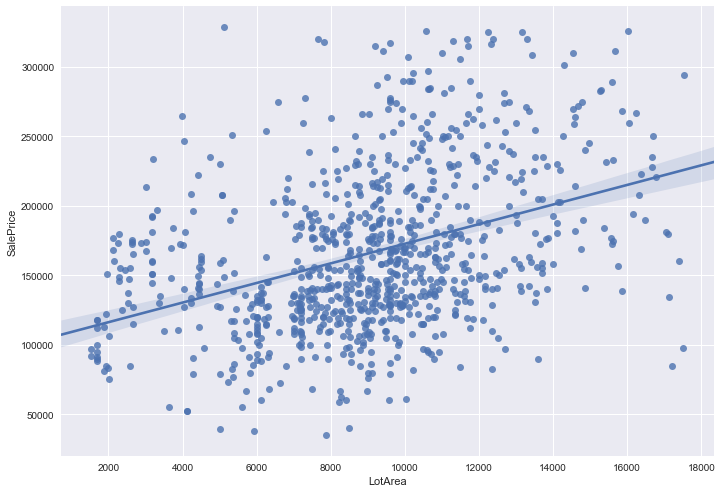

In [13]:
# Just to see hw very different it looks when we remove the most extreme outliers from both variables

# Create a df that with outliers removed from both LotArea and SalePrice
df_train2 = df_train[(df_train['LotArea'] <= 17550) & (df_train['SalePrice'] <= 330000)]

# Same plot as above, but using df with extreme outliers removed.
sns.regplot(df_train2['LotArea'], df_train2['SalePrice']);

    # It's remarkable how different this shape looks after removing those extreme observations!
    # Notice how much thinner the confidence interval is -that's a good thing.  
    # Again, looking at the CI, it appears thinner in the middle then bows out toward the far right and left edges. This
    #  suggests that at the extreme edges it's a little more iffy, but that's fairly natural and expected. When
    #  you think about what that really means, it's probably that there's a few homes that kind of break the relationship 
    #  a bit.  These would be a few small lots with expensive homes, and a few large lots with cheap homes.
    # This is a LOT more like what we want.  There's still a lot of distance between some points and the line,
    #  but at least the variance is more or less constant.
    # That direction up and to the right is visible in the regression line as we suspected.                       
                     

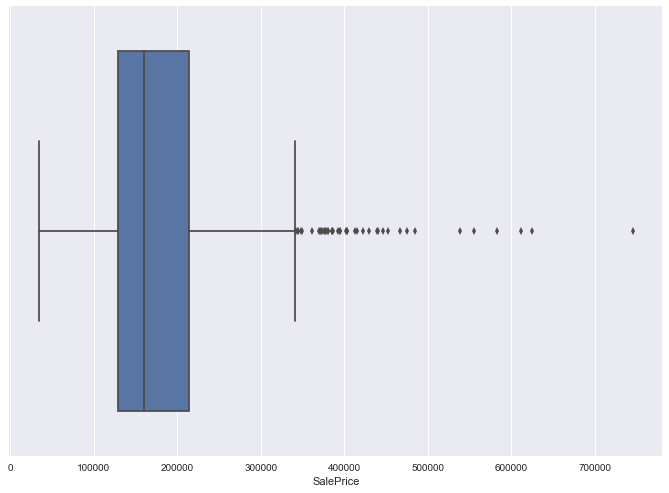

In [14]:
# Use a boxplot to get an idea about the shape of SalePrice.
sns.boxplot(df_train['SalePrice']);

    # Remember, the lines in the plot are meaningful -they tell us the median, upper and lower quartile, 
    #  skew and extreme observations.
    # We already knew there were extreme outliers, but this is a better way to view how many exactly and 
    #  how they're grouped.  It could be ust a couple big ones, or a real trend with a subset of the data.


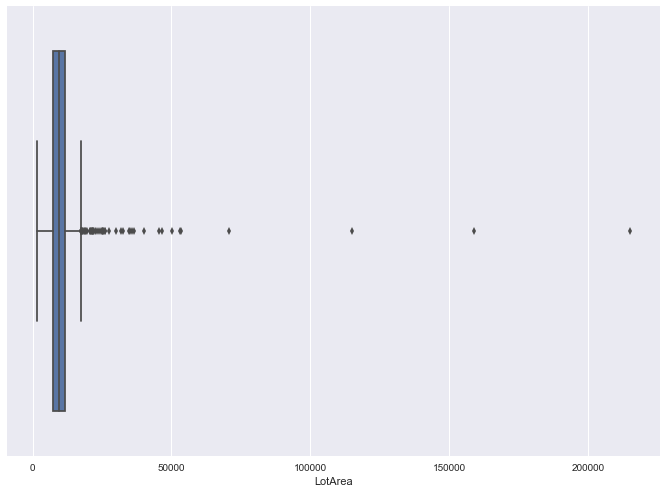

In [15]:
# Use a boxplot to get an idea about the shape of LotArea.

sns.boxplot(df_train['LotArea']);

    # It's kind of crazy how skinny the box has to be just to even show the most extreme observations.
    # In this case, it's much more obvious that there's a couple very extreme observations skewing the data.

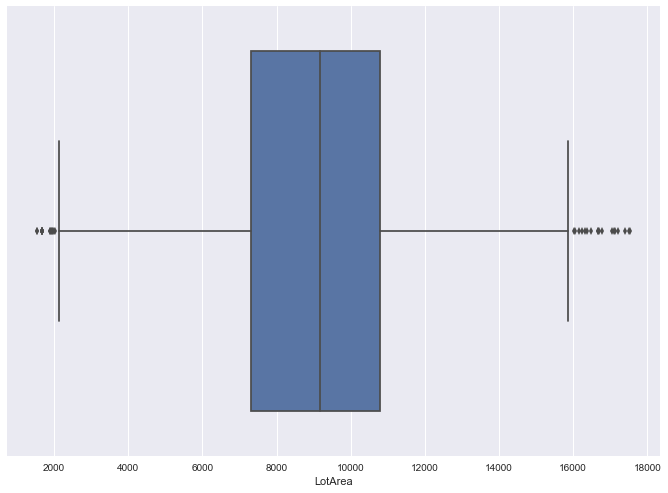

In [16]:
# Just for giggles, try it for LotArea without those extreme observations (using df we created above).

sns.boxplot(df_train2['LotArea']);

    # It's worth noting, after removing the extreme observations on the right side of the distribution, 
    #  we actually we have outliers on the left side too that we couldn't see before!
    # See how much more centered everything is now?  That's a good thing.  A histogram would look much more normal too.

#### I'm curious about these few data points with massive lot areas.

In [17]:
# Skim some of the rows with massive lot areas.
df_train[df_train['LotArea'] > 17550]

    # Here, I'm kind of skimming for a trend to see if there's any consistency in the rows that might correlate with 
    # these massive lot sizes.  I'm mainly just scanning here, and I'm particularly looking for the possibility
    # there's a categorical variable that is common to most of these that helps explain.
    # Nothing jumps out at me.


,Column 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
6,876,877,20,RL,94.0,25286,Pave,,Reg,HLS,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,4,5,1963,1963,Gable,CompShg,HdBoard,Plywood,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,633,Unf,0,431,1064,GasA,Gd,Y,SBrkr,1040,0,0,1040,1,0,1,0,3,1,TA,5,Typ,0,,Attchd,1963.0,Unf,2,648,TA,TA,Y,0,0,0,0,0,0,,,,0,1,2007,WD,Normal,132250
13,1057,1058,60,RL,NaN,29959,Pave,,IR2,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,7,6,1994,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,595,Unf,0,378,973,GasA,Ex,Y,SBrkr,979,871,0,1850,0,0,2,1,3,1,Gd,7,Typ,1,Gd,BuiltIn,1994.0,Fin,2,467,TA,TA,Y,168,98,0,0,0,0,,,,0,1,2009,WD,Normal,248000
32,943,944,90,RL,100.0,25000,Pave,,Reg,Low,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,1Story,5,4,1967,1967,Gable,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Av,Unf,0,Unf,0,1632,1632,GasA,TA,Y,SBrkr,1632,0,0,1632,0,0,2,0,4,2,TA,8,Typ,0,,Attchd,1967.0,Unf,2,576,TA,TA,P,0,0,0,0,0,0,,,,0,6,2007,WD,Normal,143000
79,113,114,20,RL,NaN,21000,Pave,,Reg,Bnk,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,5,1953,1953,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,184.0,TA,Gd,CBlock,Gd,TA,Mn,ALQ,35,Rec,869,905,1809,GasA,TA,Y,SBrkr,2259,0,0,2259,1,0,2,0,3,1,Gd,7,Typ,2,Gd,Basment,1953.0,Unf,2,450,TA,TA,Y,166,120,192,0,0,0,,MnPrv,,0,10,2007,COD,Abnorml,217000
91,53,54,20,RL,68.0,50271,Pave,,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,Gd,TA,CBlock,Ex,TA,Gd,GLQ,1810,Unf,0,32,1842,GasA,Gd,Y,SBrkr,1842,0,0,1842,2,0,0,1,0,1,Gd,5,Typ,1,Gd,Attchd,1981.0,Fin,3,894,TA,TA,Y,857,72,0,0,0,0,,,,0,11,2006,WD,Normal,385000
95,171,172,20,RL,141.0,31770,Pave,,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639,Unf,0,441,1080,GasA,Fa,Y,SBrkr,1656,0,0,1656,1,0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2,528,TA,TA,P,210,62,0,0,0,0,,,,0,5,2010,WD,Normal,215000
101,1277,1278,80,RL,NaN,17871,Pave,,IR1,Lvl,AllPub,CulDSac,Gtl,NWAmes,Norm,Norm,1Fam,SLvl,6,5,1967,1976,Gable,CompShg,HdBoard,HdBoard,BrkFace,359.0,TA,TA,CBlock,Gd,TA,Av,ALQ,528,Unf,0,1152,1680,GasA,Fa,Y,SBrkr,1724,0,0,1724,1,0,1,1,3,1,TA,7,Typ,1,Gd,Attchd,1967.0,RFn,2,480,TA,TA,Y,0,0,0,0,0,0,,,,0,6,2009,WD,Normal,197900
141,451,452,20,RL,62.0,70761,Pave,,IR1,Low,AllPub,Inside,Mod,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,655,Unf,0,878,1533,GasA,TA,Y,SBrkr,1533,0,0,1533,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1975.0,Unf,2,576,TA,TA,Y,200,54,0,0,0,0,,,,0,12,2006,WD,Normal,280000
143,706,707,20,RL,NaN,115149,Pave,,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219,Unf,0,424,1643,GasA,TA,Y,SBrkr,1824,0,0,1824,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2,739,TA,TA,Y,380,48,0,0,0,0,,,,0,6,2007,WD,Normal,302000
159,364,365,60,RL,NaN,18800,Pave,,IR1,Lvl,AllPub,FR2,Gtl,NWAmes,Norm,Norm,1Fam,2Story,6,5,1976,1976,Gable,CompShg,HdBoard,HdBoard,BrkFace,120.0,TA,TA,PConc,Gd,TA,Mn,GLQ,712,Unf,0,84,796,GasA,TA,Y,SBrkr,790,784,0,1574,1,0,2,1,3,1,TA,6,Typ,1,TA

In [18]:
# Check the distributions of only the massive lot records.
# I'll skim this compared to the plot below just looking for any numbers that are massively different
#  from one to the other or that seem to show some sort of trend in one vs the other.
df_train[df_train['LotArea'] > 17550].describe()


,Column 0,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,49.000000,49.000000,49.000000,31.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,48.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,777.346939,778.346939,51.224490,101.967742,36367.693878,6.346939,5.673469,1961.142857,1981.693878,148.510204,687.775510,71.918367,556.163265,1315.857143,1495.877551,504.061224,29.448980,2029.387755,0.653061,0.081633,1.714286,0.469388,3.122449,1.040816,7.551020,1.142857,1967.395833,2.102041,581.918367,170.530612,83.081633,29.122449,9.346939,27.795918,25.510204,179.591837,6.530612,2007.551020,240362.653061
std,411.807831,411.807831,36.990013,53.739175,36106.153649,1.507634,1.264709,28.564984,19.783415,266.815723,592.382628,205.761374,432.097469,491.885742,434.403597,571.927859,117.950742,736.504973,0.663043,0.276642,0.707107,0.543984,1.033454,0.199915,2.131717,0.645497,23.983806,0.653353,230.705245,198.297662,99.504153,96.432972,47.443629,80.165449,127.058078,1186.377468,3.156356,1.354948,110393.629190
min,53.000000,54.000000,20.000000,42.000000,17600.000000,4.000000,4.000000,1882.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,720.000000,0.000000,0.000000,988.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,112000.000000
25%,422.000000,423.000000,20.000000,63.500000,20896.000000,5.000000,5.000000,1954.000000,1963.000000,0.000000,57.000000,0.000000,140.000000,1021.000000,1236.000000,0.000000,0.000000,1572.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1957.250000,2.000000,450.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2006.000000,168000.000000
50%,769.000000,770.000000,50.000000,100.000000,25000.000000,6.000000,5.000000,1963.000000,1986.000000,0.000000,633.000000,0.000000,441.000000,1360.000000,1473.000000,192.000000,0.000000,1824.000000,1.000000,0.000000,2.000000,0.000000,3.000000,1.000000,7.000000,1.000000,1965.500000,2.000000,529.000000,155.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2007.000000,215000.000000
75%,1169.000000,1170.000000,60.000000,132.000000,35133.000000,7.000000,7.000000,1977.000000,2002.000000,184.000000,1159.000000,0.000000,878.000000,1598.000000,1686.000000,915.000000,0.000000,2380.000000,1.000000,0.000000,2.000000,1.000000,4.000000,1.000000,9.000000,2.000000,1982.250000,2.000000,648.000000,264.000000,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,274970.000000
max,1446.000000,1447.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2007.000000,2008.000000,1378.000000,2260.000000,869.000000,1632.000000,3138.000000,3138.000000,1796.000000,572.000000,4676.000000,2.000000,1.000000,3.000000,2.000000,5.000000,2.000000,12.000000,2.000000,2007.000000,4.000000,1356.000000,857.000000,406.000000,552.000000,290.000000,410.000000,738.000000,8300.000000,12.000000,2010.000000,625000.000000


In [19]:
# Compare the massive lots against the rest to see if there are any trends.
df_train[df_train['LotArea'] < 17550].describe()

    # I don't see anything when comparing these that makes me think there's a major interaction making this happen. 
    # If I was really worried about it I could also check these against some of categorical variables,
    #  which is the kind of thing that's likely to be more informative.  For example, it could be that some are
    #  zoned differently as farm land or have lots of undeveloped/uninhabitable land.  Just skimming the data dictionary,
    #  LandContour, MSZoning, LandSlope, Neighborhood could all have a relationship with LotArea and SalePrice.

,Column 0,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,929.000000,929.000000,929.000000,774.000000,929.000000,929.000000,929.000000,929.000000,929.000000,926.000000,929.000000,929.000000,929.000000,929.000000,929.00000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,870.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,721.037675,722.037675,57.373520,68.735142,9218.722282,6.040904,5.589882,1970.952637,1984.588805,99.590713,417.893434,50.930032,570.731970,1039.555436,1139.18084,325.907427,4.561895,1469.650161,0.404736,0.059203,1.543595,0.365985,2.862217,1.046286,6.434876,0.576964,1978.434483,1.726588,458.350915,91.379978,42.355221,23.529602,1.341227,15.514532,2.473628,30.086114,6.252960,2007.798708,176510.739505
std,422.998491,422.998491,43.728337,21.313307,3202.353341,1.381234,1.110658,30.096181,20.836052,174.334558,420.385871,167.285486,454.174958,418.076545,365.88700,420.971570,42.626570,488.333116,0.497644,0.240652,0.535873,0.495198,0.804328,0.220231,1.562736,0.635470,24.661197,0.761799,208.298773,118.654884,61.565066,61.921699,15.648304,57.384292,37.763180,204.070625,2.682469,1.341222,76818.354621
min,0.000000,1.000000,20.000000,21.000000,1533.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.00000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,357.000000,358.000000,20.000000,59.000000,7438.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,0.000000,216.000000,795.000000,874.00000,0.000000,0.000000,1111.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,312.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,128000.000000
50%,717.000000,718.000000,50.000000,69.000000,9297.000000,6.000000,5.000000,1972.000000,1994.000000,0.000000,360.000000,0.000000,470.000000,975.000000,1073.00000,0.000000,0.000000,1416.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,467.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,158500.000000
75%,1087.000000,1088.000000,70.000000,80.000000,11075.000000,7.000000,6.000000,2000.000000,2004.000000,160.750000,695.000000,0.000000,816.000000,1253.000000,1338.00000,698.000000,0.000000,1728.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,572.000000,168.000000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,208500.000000
max,1458.000000,1459.000000,190.000000,182.000000,17542.000000,10.000000,9.000000,2009.000000,2010.000000,1600.000000,2188.000000,1127.000000,2336.000000,3206.000000,3228.00000,2065.000000,528.000000,4476.000000,2.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1390.000000,668.000000,547.000000,386.000000,245.000000,480.000000,648.000000,3500.000000,12.000000,2010.000000,745000.000000


#### I'll try a couple transformations of the data here:

1) Scaling:  Setting the distribution of the data on a scaled distribution where every point falls between 0-1.

2) Quantile transformation: Best to just read about it here: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html

3) Quantile r=transform with normal output distribution:  Similar to above, but transforms to a normal distribution.

4) Binning:  Changing the linear value into an ordinal/categorical variable by putting the values into brackets.  Look for this one after I work on the categorical variable.

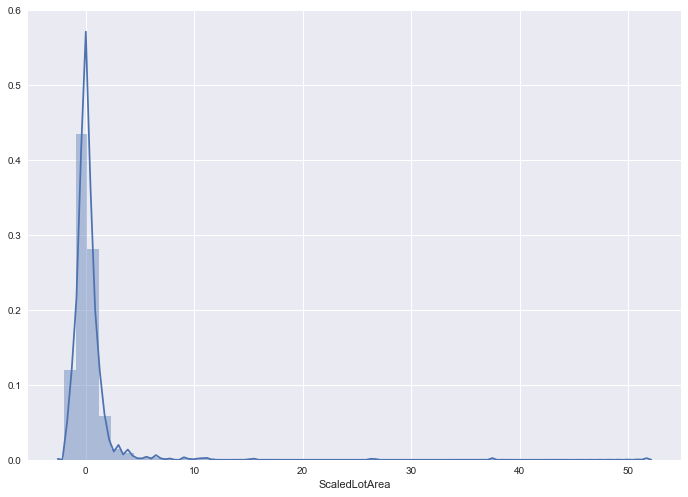

In [20]:
# Scaling

# Since I have a lot of outliers, I use sklearn RobustScaler
scaler = RobustScaler()

    # Create avariable to store my new scaled variable and intialize it with unscaled values.
df_train['ScaledLotArea'] = df_train['LotArea']

    # Scale the values in the newly created variable.
df_train[['ScaledLotArea']] = scaler.fit_transform(df_train[['LotArea']])

# Check the distribution
sns.distplot(df_train['ScaledLotArea']);

    # My data is still the same bad shape, just at a different scale. Not sure I gained much here.
    # Scaling is generally mroe helpful when either your algorithm relies on or requires it, or when it
    #  helps to compare to variables to each other.  For example, if we wanted to combine 1st and 2nd floor 
    #  livable square feet, we might scale them each first so that 1st floor doesn't drown out the effect of 2nd floor
    #  by virtue of so often just being a larger number.  Not a super awesome example, but anyway...

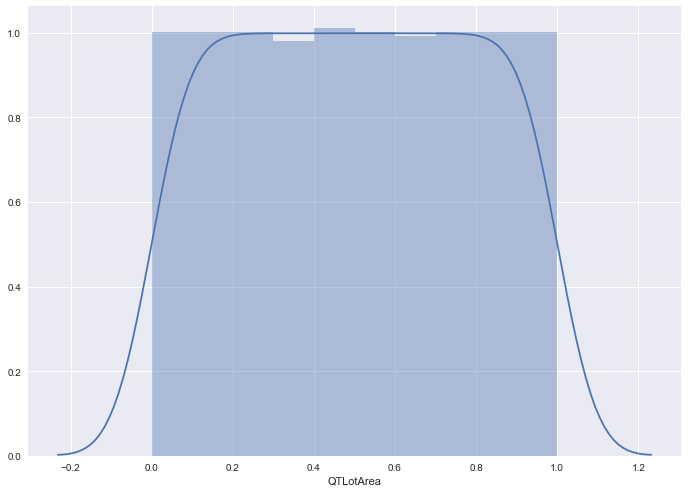

In [21]:
# Quantile transformation

# Initialize quantile transformer
quantile_transformer = QuantileTransformer(random_state = 0)

    # Create a variable to store my new snormalized variable and intialize it with un-normalized values.
df_train['QTLotArea'] = df_train['LotArea']

    # Normalize the values in the newly created variable.
df_train[['QTLotArea']] = quantile_transformer.fit_transform(df_train[['LotArea']])

# Check the distribution
sns.distplot(df_train['QTLotArea']);

    # Maybe we just look at this one together...  I'm still kind of wrapping my head around it.

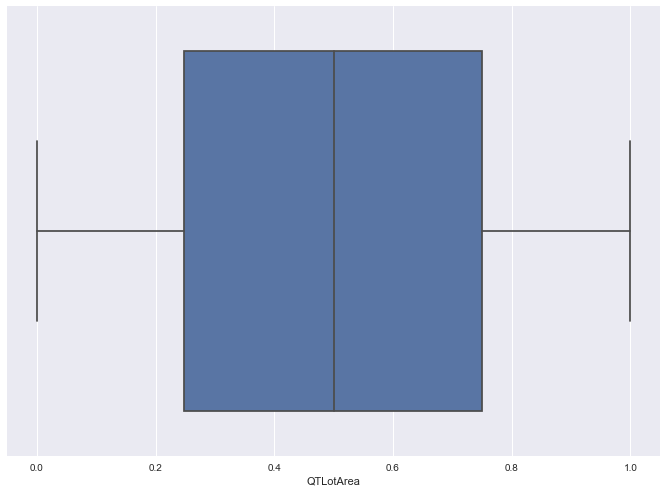

In [22]:
# Check the Quantile Transform as a boxplot.
sns.boxplot(df_train['QTLotArea']);

    # That's, literally, about as perfect of a boxplot as you can have.

In [23]:
# Check the descriptive stats
df_train['QTLotArea'].describe(percentiles=[.05,.10,.25,.75,.90,.95])

    # This is distribution is so perfect it's almost creepy.  It's the Stepford Wives of distributions.

count    9.780000e+02
mean     4.999925e-01
std      2.891141e-01
min      1.000000e-07
5%       4.904905e-02
10%      1.004601e-01
25%      2.470926e-01
50%      5.000003e-01
75%      7.502503e-01
90%      8.995957e-01
95%      9.499610e-01
max      9.999999e-01
Name: QTLotArea, dtype: float64

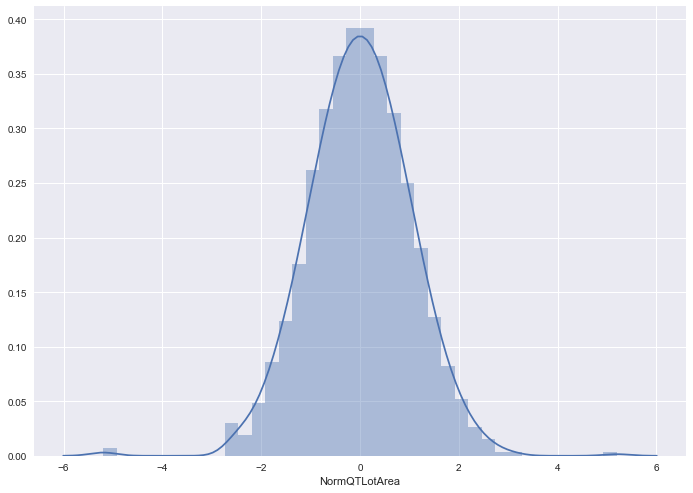

In [24]:
# Try the transformation again, but with normalization

# Quantile transformation w/ normalization

# Initialize quantile transformer
normal_quantile_transformer = QuantileTransformer(output_distribution = 'normal', random_state = 0)

    # Create a variable to store my new snormalized variable and intialize it with un-normalized values.
df_train['NormQTLotArea'] = df_train['LotArea']

    # Normalize the values in the newly created variable.
df_train[['NormQTLotArea']] = normal_quantile_transformer.fit_transform(df_train[['LotArea']])

# Check the distribution
sns.distplot(df_train['NormQTLotArea']);


In [25]:
# Check the descriptive stats of all transformations together.
df_train[['LotArea', 'ScaledLotArea', 'QTLotArea', 'NormQTLotArea']].describe(percentiles=[.05, .10, .25, .75, .90, .95])

,LotArea,ScaledLotArea,QTLotArea,NormQTLotArea
count,978.000000,978.000000,9.780000e+02,9.780000e+02
mean,10578.946830,0.272583,4.999925e-01,-1.827314e-03
std,10435.691359,2.614642,2.891141e-01,1.028132e+00
min,1533.000000,-1.993862,1.000000e-07,-5.199338e+00
5%,3182.000000,-1.580708,4.904905e-02,-1.654145e+00
10%,5043.700000,-1.114262,1.004601e-01,-1.278950e+00
25%,7508.750000,-0.496649,2.470926e-01,-6.836858e-01
50%,9491.000000,0.000000,5.000003e-01,7.106534e-07
75%,11500.000000,0.503351,7.502503e-01,6.752775e-01
90%,14590.300000,1.277620,8.995957e-01,1.279255e+00


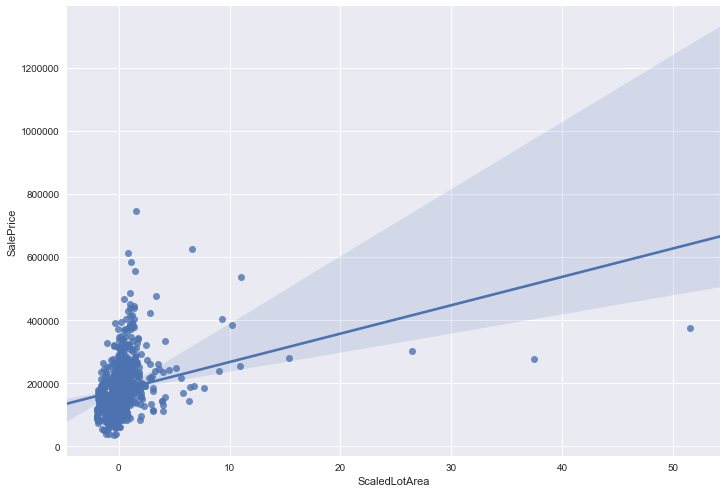

In [26]:
# Scaled regression plot.
sns.regplot(df_train['ScaledLotArea'], df_train['SalePrice']);

    # Basically, just about the same (and as bad) as our original.

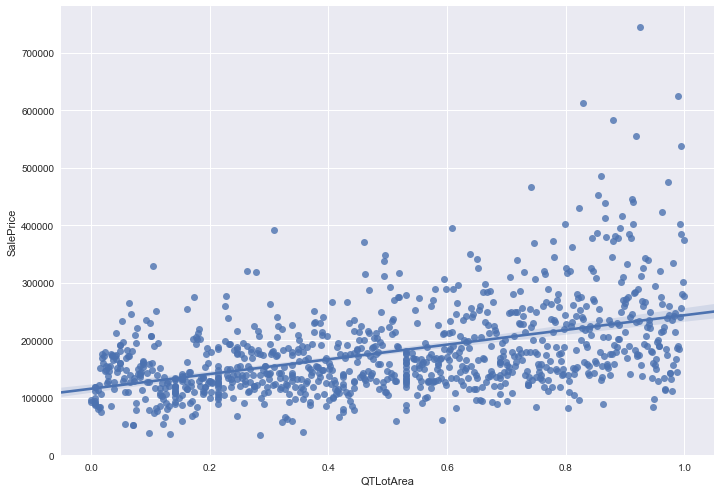

In [27]:
# QT regression plot.
sns.regplot(df_train['QTLotArea'], df_train['SalePrice']);

    # Imagine how nice this would look with the outliers removed?
    # My guess is it would have nice, constant variance like below and without falling apart at right side like 
    #  this does -which would also pull the regression line up a little bit so that so much of the error
    #  isn't mostly below the line like here.  (The regression line is definitely "chasing" those outliers up to the right, 
    #  throwing everything off in the process)

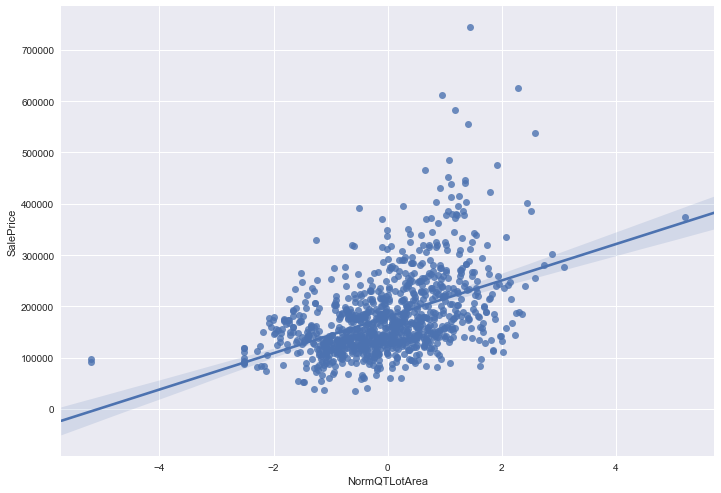

In [28]:
# Normalized QT boxplot.
sns.regplot(df_train['NormQTLotArea'], df_train['SalePrice']);

    # Not terrible, although the outliers are clearly having an effect on it.
    # This could end up being the best transformation after extreme outliers are removed, but for now, 
    #  I still like the looks of the regular QT transform.

In [29]:
# Reinitialize the df with the extreme obs removed to add the transformed variables.
df_train2 = df_train[(df_train['LotArea'] <= 17550) & (df_train['SalePrice'] <= 330000)]

# Look at my categorical variable: SaleCondition

#### NOTE: I said I'd also try binning Lot Area, and I will, but when you bin it you are basically turining it into a categorical variable, so we will return to that later.

In [30]:
# Check out each class of my categrical by the average sale price in each.
df_train[['SalePrice', 'SaleCondition']].groupby('SaleCondition').mean().reset_index().sort_values('SalePrice')

    # What we're looking for here is a significant difference in average SalePrice per class.  If we see a substantial
    #  difference, it might mean that the category class has an impact on the SalePrice.
    # Looking below, I see that Abnormal is nearly half the average price of Partial, and Partial is $100K higher
    #  average price than the next highest. -keep in mind, this could still be affected by outliers.

,SaleCondition,SalePrice
1,AdjLand,127500.000000
0,Abnorml,147091.361111
3,Family,161269.230769
2,Alloca,166532.250000
4,Normal,174078.456897
5,Partial,275313.592105


In [31]:
# Check the same thing, but using the df I removed extreme observations from earlier.
df_train2[['SalePrice', 'SaleCondition']].groupby('SaleCondition').mean().reset_index().sort_values('SalePrice')

    # The outliers were definitely having an effect, as we can see Partial dropped $50K, which is a lot.  But, there's still
    #  a fairly sizable difference between Partial and the rest.

,SaleCondition,SalePrice
1,AdjLand,127500.000000
2,Alloca,130386.333333
0,Abnorml,136243.794118
3,Family,161269.230769
4,Normal,164802.747004
5,Partial,225053.943396


In [32]:
# Get a count of how many fall into each category class.
df_train[['SalePrice', 'SaleCondition']].groupby('SaleCondition').count().reset_index().sort_values('SalePrice')

    # Good thing we looked at this, because a lot of these classes are too small to call it a trend.  It's borderline if you
    #  would want to consider "Family" as a separate class with only 13 values, but I might not just because it's very 
    #  similar to "Normal" and these can probably be combined.
    #  That basically gives us 3 classes to look at:  Abnormal (72 cnt, $136K avg), Normal(812, $165K), Partial(76, $225K).
    #  There's a good amount of difference in those three classes.
    # I could also see arguments both for creating an "Other" class for Alloca and AdjLand, or for combining them with 
    #  "Abnormal".  Here is where a BA could really help us out to understand the differences.

,SaleCondition,SalePrice
1,AdjLand,1
2,Alloca,4
3,Family,13
0,Abnorml,72
5,Partial,76
4,Normal,812


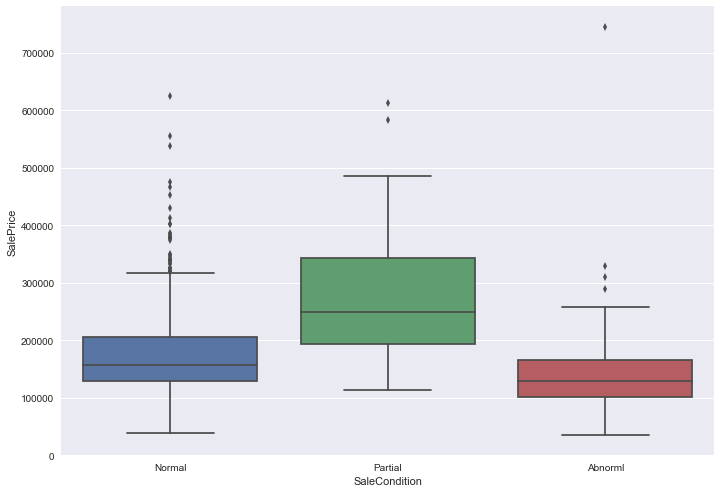

In [33]:
# Here's the boxplot of each category with the extreme observations in it.
# The order argument not only orders it so the classes appear in consistent order, but it also ignores 
#  the classes I don't explicitly include.

sns.boxplot(x='SaleCondition', y='SalePrice', data=df_train,
           order = ['Normal', 'Partial', 'Abnorml']);

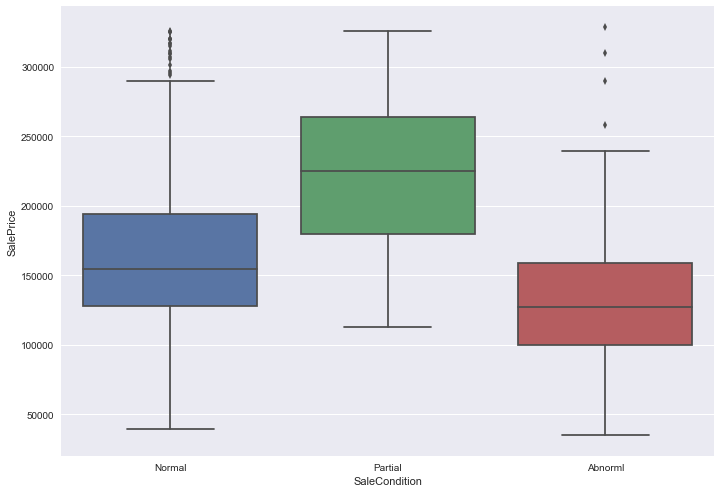

In [34]:
# Here's the boxplot of each category with the extreme observations removed.
sns.boxplot(x='SaleCondition', y='SalePrice', data=df_train2,
           order = ['Normal', 'Partial', 'Abnorml']);

    # The distributions look about the same as what we saw above, but this was a good excercise anyway
    #  and should be a part of a good categorical analysis.
    # Another thing we get to see here is the distributions within the classes.  If any of these boxplots 
    #  looked heavily skewed or influenced by extreme observations (like "Abnorml" above), that might be
    #  worth investigating.

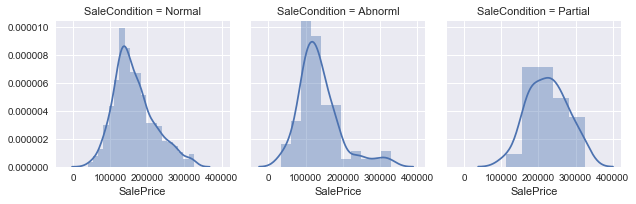

In [35]:
# Check the shape of the target over the different classes.
# df_train2 -my set with extreme obs removed- is used here just for better illustration.
# The pipes (|) mean 'OR'.

# Create a Seaborn FacetGrid object with the data I want to use and the value I want used for my columns.
# If I had another categorical I was cross-examining, I could use row = '' to set it as a 2d grid. 
g = sns.FacetGrid(df_train2[(df_train2['SaleCondition'] == 'Normal') | 
                           (df_train2['SaleCondition'] == 'Partial') |
                           (df_train2['SaleCondition'] == 'Abnorml')], 
                           col='SaleCondition')

# Display my histograms in the grid object I created.
g.map(sns.distplot, 'SalePrice');

    # This is handy-dandy.
    # What I'm looking at here is to see if the distribution varies greatly across the classes.  I already know that
    #  it does somewhat by looking at how avg SalePrice is different for each class, but this is not only another way 
    #  I could have spotted that, but it also gives me a better idea of if the data is normally distributed or more 
    #  constant within the class.

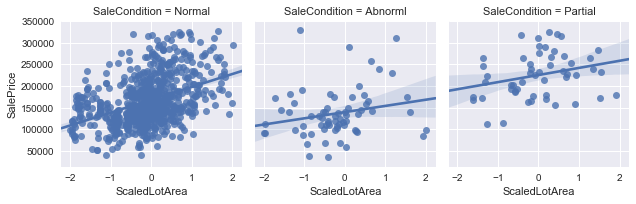

In [36]:
# Regression plot against classes with extreme obs removed..
g = sns.FacetGrid(df_train2[(df_train2['SaleCondition'] == 'Normal') | 
                           (df_train2['SaleCondition'] == 'Partial') |
                           (df_train2['SaleCondition'] == 'Abnorml')], 
                           col='SaleCondition')

g.map(sns.regplot, 'ScaledLotArea','SalePrice');

# Now, lets try binning LotArea

In [37]:
# I'm going to start be seeing what the distribution looks like again with the extreme values removed.
# I'll set my percentiles up so I can see both my quartiles and what it looks like at each 10%

df_train2['LotArea'].describe(percentiles=[.1,.2, .25,.3,.4,.6,.7,.75,.8,.9])

    # I don't love how these break out over the percentiles, so, and I donlt know if this is a thing
    #  or not, but I'm going to try binning based on the std.  It's used for a lot of things like 
    #  determining outliers and in certain transformations, so why not?


count      889.000000
mean      9046.303712
std       3136.799668
min       1533.000000
10%       4556.800000
20%       6899.200000
25%       7313.000000
30%       7777.800000
40%       8529.200000
50%       9158.000000
60%       9741.200000
70%      10470.200000
75%      10800.000000
80%      11340.000000
90%      13010.200000
max      17542.000000
Name: LotArea, dtype: float64

In [38]:
# Just for show, I've created a variable for the ranges, and another for an ID that will be possibly useful 
#  as an ordinal variable.  An ordinal variable is one that is categorical, but the categories have a logical 
#  order.  For instance, in this case my first range 0-2778 is less than 2778-5912, so there is an increase 
#  in the values for an increase in range ID.  It's like saying "On a scale of 1-6, how big is the lot?"

# NOTE: Since I'm using std, I want to count from the mean because this is how my data is actually segmented.
#  This gives me the best chance of putting my bins into somethign that actually represents a normal 
#  distribution -which, by looking at my bin sizes below you can see worked pretty well. 

df_train2['LotAreaRangeDesc'] = pd.cut(df_train2['LotArea'], [0, 2778, 5912, 9046, 12180, 15314, 999999])
df_train2['LotAreaRangeID'] = pd.cut(df_train2['LotArea'], [0, 2778, 5912, 9046, 12180, 15314, 999999], labels=False)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [39]:
# Take a look at what some of the bins we created.
df_train2[['LotAreaRangeDesc', 'LotAreaRangeID']].head(10);

In [40]:
# Check it out like a pivot table
df_train2[['LotAreaRangeID', 'LotAreaRangeDesc', 'SalePrice']].groupby('LotAreaRangeDesc').mean().reset_index()

    # We see that for the bins/classes I created, they average price does increase for each consecutive
    #  bin.  When I tried breaking these up some ofhter ways, this was not necessarily the case and these 
    #  could have ended up being useless as ordinal variables, but this method appears to have worked very well.

,LotAreaRangeDesc,LotAreaRangeID,SalePrice
0,"(0, 2778]",0.0,127879.487179
1,"(2778, 5912]",1.0,144960.857143
2,"(5912, 9046]",2.0,145848.229452
3,"(9046, 12180]",3.0,177729.651163
4,"(12180, 15314]",4.0,208496.021277
5,"(15314, 999999]",5.0,209324.551724


In [41]:
# Check the size of each bin
df_train2[['LotAreaRangeDesc', 'SalePrice']].groupby('LotAreaRangeDesc').count().reset_index()

    # I'm not looking necessarily for bins with even numbers of records in them, I want bins
    #  that have statistically similar records in them.  When you look at the counts here, it's
    #  funny how you can almost see the normal distribution in them: fewer records in the bins 
    #  on the edges and the mass of records in the central bins.  This is not completely by accident;
    #  it has everything to do with how I used the std and mean to create them.

,LotAreaRangeDesc,SalePrice
0,"(0, 2778]",39
1,"(2778, 5912]",91
2,"(5912, 9046]",292
3,"(9046, 12180]",344
4,"(12180, 15314]",94
5,"(15314, 999999]",29


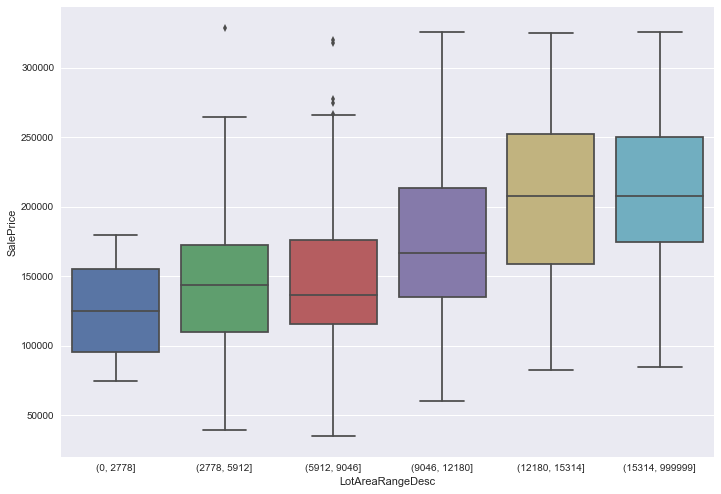

In [42]:
# Boxplots for SalePrice by LotAreaRangeDesc
sns.boxplot(x='LotAreaRangeDesc', y='SalePrice', data=df_train2);

    # To t=really treat these as ordinal variables, I'd want to see more distance seperating them -meaning
    #  the far left one would be lower, the next one to the right, higher, the next to the right even higher, 
    #  and so on.  In fact, that 5912-9046 bin has a median below the one to the left and probably only mostly 
    #  looks about even due to those outliers up tip.  This makes me think the 2778-5912 bin should maybe be 
    #  a little bigger. I'm also not seeing much seperation between two bins on the far right.  Possibly, they
    #  should be combined.

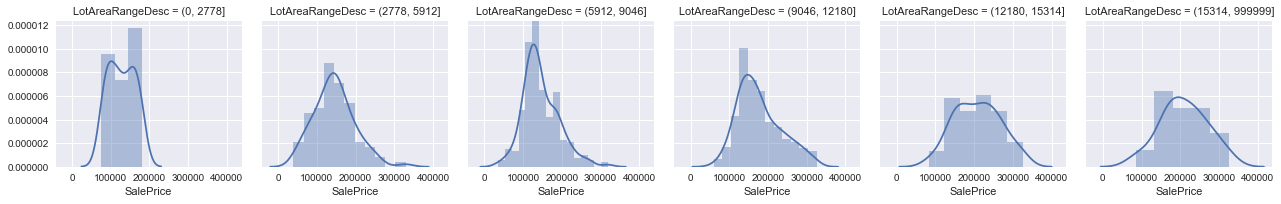

In [43]:
# Histograms for SalePrice by LotAreaRangeDesc
g = sns.FacetGrid(df_train2, col='LotAreaRangeDesc')
g.map(sns.distplot, 'SalePrice');

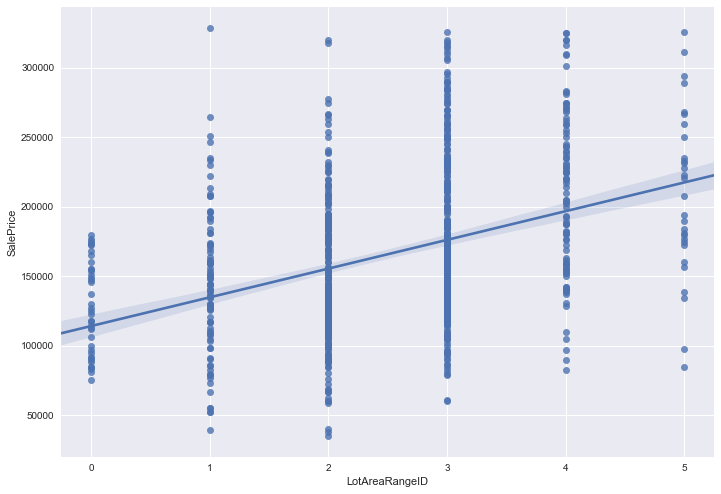

In [44]:
# Regplot for my new binned LotArea variable.
sns.regplot(df_train2['LotAreaRangeID'],df_train2['SalePrice']);

    # This looks a little crazy at frst glance, but it's the same as  all the other regplots, only with much fewer values
    #  so those vertical lines really stand out.  The good thing here is that the CI is narrow, and that regression line
    #  clearly trends upward.  I really don't love having a variable that I'm calling a "linear" variable that only have a 
    #  scale of 0-5, but I supose there's worse things going on in the world.

In [45]:
df_train2.head()

,Column 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,ScaledLotArea,QTLotArea,NormQTLotArea,LotAreaRangeDesc,LotAreaRangeID
0,806,807,80,RL,75.0,9750,Pave,,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,SLvl,5,5,1967,1967,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,TA,TA,Av,ALQ,400,Rec,480,100,980,GasA,Gd,Y,SBrkr,980,0,0,980,0,0,2,0,3,1,TA,6,Typ,0,,Attchd,1967.0,Fin,1,384,TA,TA,Y,68,0,0,0,0,0,,,,0,10,2006,WD,Normal,135500,0.064892,0.552553,0.132113,"(9046, 12180]",3
1,911,912,20,RL,NaN,9286,Pave,,IR1,Lvl,AllPub,CulDSac,Mod,CollgCr,Norm,Norm,1Fam,1Story,5,7,1977,1989,Gable,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,Gd,Gd,Av,ALQ,196,Unf,0,1072,1268,GasA,TA,Y,SBrkr,1268,0,0,1268,0,0,1,1,3,1,Gd,5,Typ,0,,Detchd,1978.0,Unf,1,252,TA,TA,Y,173,0,0,0,0,0,,,,0,10,2009,WD,Normal,143500,-0.051362,0.473303,-0.066970,"(9046, 12180]",3
2,502,503,20,RL,70.0,9170,Pave,,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1965,1965,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,698,GLQ,96,420,1214,GasA,Ex,Y,SBrkr,1214,0,0,1214,1,0,1,0,2,1,TA,6,Typ,0,,Detchd,1965.0,Unf,2,461,Fa,Fa,Y,0,0,184,0,0,0,,GdPrv,Shed,400,4,2007,WD,Normal,140000,-0.080426,0.456508,-0.109236,"(9046, 12180]",3
3,982,983,20,RL,43.0,3182,Pave,,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,1Fam,1Story,7,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,BrkFace,16.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1266,1266,GasA,Ex,Y,SBrkr,1266,0,0,1266,0,0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2007.0,Fin,2,388,TA,TA,Y,100,16,0,0,0,0,,,,0,3,2008,WD,Normal,159895,-1.580708,0.049049,-1.654145,"(2778, 5912]",1
4,681,682,50,RH,55.0,4500,Pave,Pave,IR2,Bnk,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1932,2000,Gable,CompShg,VinylSd,Stucco,None,0.0,TA,TA,BrkTil,TA,TA,No,Rec,182,Unf,0,611,793,GasA,Ex,Y,SBrkr,848,672,0,1520,0,0,1,0,3,1,TA,6,Typ,0,,Detchd,1968.0,Unf,1,281,TA,TA,Y,0,0,56,0,0,0,,,,0,7,2009,WD,Abnorml,159434,-1.250485,0.088088,-1.352623,"(2778, 5912]",1


In [122]:
df_train2['EraBuilt'] = pd.cut(df_train2['YearBuilt'], [0, 1930, 1975, 1995, 9999])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [123]:
df_train2.loc[df_train2['Neighborhood'] == 'StoneBr', 'Rate'] = 3
df_train2.loc[df_train2['Neighborhood'] == 'NoRidge', 'Rate'] = 3
df_train2.loc[df_train2['Neighborhood'] == 'NridgHt', 'Rate'] = 3
df_train2.loc[df_train2['Neighborhood'] == 'Timber', 'Rate'] = 2
df_train2.loc[df_train2['Neighborhood'] == 'Somerst', 'Rate'] = 2
df_train2.loc[df_train2['Neighborhood'] == 'Veenker', 'Rate'] = 2
df_train2.loc[df_train2['Neighborhood'] == 'Crawfor', 'Rate'] = 2
df_train2.loc[df_train2['Neighborhood'] == 'ClearCr', 'Rate'] = 2
df_train2.loc[df_train2['Neighborhood'] == 'CollgCr', 'Rate'] = 2
df_train2.loc[df_train2['Neighborhood'] == 'Blmngtn', 'Rate'] = 2
df_train2.loc[df_train2['Neighborhood'] == 'NWAmes', 'Rate'] = 2
df_train2.loc[df_train2['Neighborhood'] == 'Gilbert', 'Rate'] = 2
df_train2.loc[df_train2['Neighborhood'] == 'SawyerW', 'Rate'] = 2
df_train2.loc[df_train2['Neighborhood'] == 'Mitchel', 'Rate'] = 1
df_train2.loc[df_train2['Neighborhood'] == 'Blueste', 'Rate'] = 1
df_train2.loc[df_train2['Neighborhood'] == 'NPkVill', 'Rate'] = 1
df_train2.loc[df_train2['Neighborhood'] == 'NAmes', 'Rate'] = 1
df_train2.loc[df_train2['Neighborhood'] == 'SWISU', 'Rate'] = 1
df_train2.loc[df_train2['Neighborhood'] == 'Sawyer','Rate'] = 1
df_train2.loc[df_train2['Neighborhood'] == 'OldTown','Rate'] = 1
df_train2.loc[df_train2['Neighborhood'] == 'BrkSide','Rate'] = 1
df_train2.loc[df_train2['Neighborhood'] == 'Edwards','Rate'] = 1
df_train2.loc[df_train2['Neighborhood'] == 'BrDale', 'Rate'] = 1
df_train2.loc[df_train2['Neighborhood'] == 'IDOTRR','Rate'] = 1
df_train2.loc[df_train2['Neighborhood'] == 'MeadowV','Rate'] = 1


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [124]:
df_train3 = df_train2[["LotArea", "GrLivArea", "1stFlrSF", "2ndFlrSF","SaleCondition", "Rate", "EraBuilt", "BldgType", "SalePrice"]]

In [126]:
df_train4 = pd.get_dummies(df_train3, columns = ["SaleCondition", "Rate", "EraBuilt", "BldgType"])

In [127]:
df_train4.head()

,LotArea,GrLivArea,1stFlrSF,2ndFlrSF,SalePrice,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Rate_1.0,Rate_2.0,Rate_3.0,"EraBuilt_(0, 1930]","EraBuilt_(1930, 1975]","EraBuilt_(1975, 1995]","EraBuilt_(1995, 9999]",BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
0,9750,980,980,0,135500,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0
1,9286,1268,1268,0,143500,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0
2,9170,1214,1214,0,140000,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0
3,3182,1266,1266,0,159895,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0
4,4500,1520,848,672,159434,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0


# Create Linear Regression Model

In [128]:
# Create an array with all of the predictors I want (Be sure to exclude the target!).
data_variables=df_train4.columns.values.tolist()
t = ['SalePrice']
cols=[i for i in data_variables if i not in t]

# Use the array I just created wih the column names to prep my input for my model, separating predictors and target.
# Note:  This is a very common format using big-X for my predictors and small-y for my target.
X=df_train4[cols]
y=df_train4[t]

# Our model needs an intercept so we add a column of 1s
X = sm.add_constant(X)

# Make sure they are all formatted as float numbers.
X = X.astype('float64')
y = y.astype('float64')

In [129]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary2())

                          Results: Ordinary least squares
Model:                    OLS                   Adj. R-squared:          0.810     
Dependent Variable:       SalePrice             AIC:                     20545.7649
Date:                     2018-06-28 10:48      BIC:                     20636.7767
No. Observations:         889                   Log-Likelihood:          -10254.   
Df Model:                 18                    F-statistic:             211.2     
Df Residuals:             870                   Prob (F-statistic):      2.03e-302 
R-squared:                0.814                 Scale:                   6.2426e+08
-----------------------------------------------------------------------------------
                         Coef.     Std.Err.     t    P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------------------
const                  19742.9663  3432.8418  5.7512 0.0000  13005.3467  26480.5860
LotArea           

## Interpretation

* Df of residuals and models: Relates to the degrees of freedom — “the number of values in the final calculation of a statistic that are free to vary.”
    * DF Residuals: Degrees of freedom of the residuals. Number of observations - number of parameters
    * DF Model: Number of parameters in the model (not including the constant term if present)
* R-squared: The percentage of variance our model explains.  Meaning, our model accounts for about this percentage of why this target is what it is.
* Adj R-squared:  The R-squared value adjusted based on the number of observations and the degrees-of-freedom of the residuals.
* Coef:  Amount change in the target per unit change of the predictor. (Colloquially, the "weight").
* Std. Error:  standard error -standard deviation of the sampling distribution of a statistic, most commonly of the mean.
* t scores and p-values:  In a hypothesis test, these tell you if the coefficient is statistically significant, and to what degree. (p-value less than .05 is the gold standard).
* Confidence Interval:  These are commonly 95%, but here it's actually showing 97.5%.  This tells us we're 97.5% sure the mean of this value is between these two numbers.
* F-Statistic/Prob F-Statistic: Whereas the t-test considers the significance of a single regressor, the F-test evaluates the significance of the entire regression, where the null hypothesis is that all the regressors except the constant are equal to zero
    * F-Statistic: 	A measure how significant the fit is. The mean squared error of the model divided by the mean squared error of the residuals
    * Prob (F-Statistic): The probability that you would get the above statistic, given the null hypothesis that they are unrelated.
* Log-likelihood:  The log of the likelihood function.
* AIC: The Akaike Information Criterion. Adjusts the log-likelihood based on the number of observations and the complexity of the model.
* BIC: The Bayesian Information Criterion. Similar to the AIC, but has a higher penalty for models with more parameters.

* Skewness: A measure of the symmetry of the data about the mean. Normally-distributed errors should be symmetrically distributed about the mean (equal amounts above and below the line).
* Kurtosis: A measure of the shape of the distribution. Compares the amount of data close to the mean with those far away from the mean (in the tails).
* Omnibus: D'Angostino's test. It provides a combined statistical test for the presence of skewness and kurtosis.
* Prob(Omnibus): The Omnibus statistic turned into a probability
* Jarque-Bera: A different test of the skewness and kurtosis
* Prob (JB): The Jarque-Bera statistic turned into a probability
* Durbin-Watson A test for the presence of autocorrelation (that the errors are not independent.) Often important in time-series analysis
* Cond. No: A test for multicollinearity (if in a fit with multiple parameters, the parameters are related with each other).


* The condition number is large (8e+16). This might indicate strong multicollinearity or other numerical problems.
    * A decent explanation of the error:  https://stackoverflow.com/questions/25676145/capturing-high-multi-collinearity-in-statsmodels
    *What the heck is Multicollinearity:  
    * Overview and in-depth: https://onlinecourses.science.psu.edu/stat501/node/343/
    * Intuitive explanation: https://stats.stackexchange.com/questions/1149/is-there-an-intuitive-explanation-why-multicollinearity-is-a-problem-in-linear-r
    * When is it OK?  Also, what is VIF: https://statisticalhorizons.com/multicollinearity

### Plots to Examine Model Fit

#### This section is TBD.  If anyone comes up with or finds any good ones they want to share, please do!

### VIF and Multicollinearity

This will help us determine if a variable in the model has a potential issue with multicollinearity.  The statistic it returns is called Variance Inflation Factor (VIF), and the links above in the "Interpretation" section help explain more.  

** We want VIF to be 5 or less as a rule.  So, anythign much more than that could be an issue. **

VIF tells you if the variable has an issue compared to the rest of the model without that variable.  To get a better idea of which variables might be collinear with each other, follow the same links and try to produce a matrix/plot to look at the eigen values of the correlation matrix -which you can find a decent explanation of here: https://stackoverflow.com/questions/25676145/capturing-high-multi-collinearity-in-statsmodels

In [130]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = results.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[0.0,
 2.021069031248905,
 104.29789723175875,
 60.067689311729318,
 90.808501603042373,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

In [3]:
import sys
print(sys.executable)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\python.exe


In [2]:
home

'C:\\Users\\bburns'